## NA21B075_DL_Assignment_3

Installing required libraries and setting up the environment for NLP and deep learning tasks

In [1]:
!pip install wandb
!pip install wordcloud
!pip install colour
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family
import os
import random
import time
import wandb
import re, string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from matplotlib.font_manager import FontProperties
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-lohit-deva
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 78.9 kB of archives.
After this operation, 198 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-lohit-deva all 2.95.4-4 [78.9 kB]
Fetched 78.9 kB in 1s (114 kB/s)
Selecting previously unselected package fonts-lohit-deva.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../fonts-lohit-deva_2.95.4-4_all.deb ...
Unpacking fonts-lohit-deva (2.95.4-4) ...
Setting up fonts-lohit-deva (2.95.4-4) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Lohit Devanagari


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile

tar_path = "/content/drive/MyDrive/dakshina_dataset_v1.0.tar"
extract_path = "/content/drive/MyDrive/dakshina_dataset_v1.0"

# Extract only if not already extracted
if not os.path.exists(extract_path):
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path="/content/drive/MyDrive")

def creating_data(language, path="/content/drive/MyDrive/dakshina_dataset_v1.0/{}/lexicons/{}.translit.sampled.{}.tsv"):
    # returning train tsv, val tsv, test tsv
    return path.format(language, language, "train"), path.format(language, language, "dev"), path.format(language, language, "test")


In [4]:
## functions for preprocessing data ##

def add_start_end_tokens(df, cols, sos="\t", eos="\n"):
    def add_tokens(s):
        # \t = starting token
        # \n = ending token
        return sos + str(s) + eos
    for col in cols:
        df[col] = df[col].apply(add_tokens)

def tokenize(lang, tokenizer=None):
    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')
    else:
        lang_tensor = tokenizer.texts_to_sequences(lang)
        lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')
    return lang_tensor, tokenizer

def preprocess_data(fpath, input_lang_tokenizer=None, targ_lang_tokenizer=None):
    df = pd.read_csv(fpath, sep="\t", header=None)
    add_start_end_tokens(df, [0,1])# adding start and end tokens to know when to stop predicting
    input_lang_tensor, input_tokenizer = tokenize(df[1].astype(str).tolist(),tokenizer=input_lang_tokenizer)
    targ_lang_tensor, targ_tokenizer = tokenize(df[0].astype(str).tolist(),tokenizer=targ_lang_tokenizer)
    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))
    return dataset, input_tokenizer, targ_tokenizer

In [5]:
#########################  LAYER TYPE ##########################################
def model_layer_type(name, units, dropout, return_state=False, return_sequences=False):
    temp = layers.GRU(units=units, dropout=dropout, return_state=return_state, return_sequences=return_sequences)
    if name=="rnn":
      temp = layers.SimpleRNN(units=units, dropout=dropout, return_state=return_state, return_sequences=return_sequences)
    elif name == 'lstm':
      temp = layers.LSTM(units=units, dropout=dropout, return_state=return_state, return_sequences=return_sequences)
    return temp

In [6]:
def create_layer_for_Enc(no_of_layer, layer_type, units, dropout):
    temp = []
    for i in range(no_of_layer):
        ly = model_layer_type(layer_type, units, dropout, return_state=True, return_sequences=True)
        temp.append(ly)
    return temp


class Encoder(tf.keras.Model):
    def __init__(self, layer_type, n_layers, units, encoder_vocab_size, embedding_dim, dropout):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(encoder_vocab_size, embedding_dim)
        self.dropout = dropout
        self.n_layers = n_layers
        self.units = units
        self.layer_type = layer_type
        self.rnn_layers = create_layer_for_Enc(n_layers, layer_type, units, dropout)

    def call(self, x, hidden):
        raise NotImplementedError("Use Enc_out_state() instead")

    def Enc_out_state(self, x, hidden):
        x = self.embedding(x)
        outputs = x

        for i in range(self.n_layers):
            if self.layer_type == "lstm":
                outputs, state_h, state_c = self.rnn_layers[i](outputs, initial_state=hidden)
                hidden = [state_h, state_c]
            else:
                outputs, state_h = self.rnn_layers[i](outputs, initial_state=hidden)
                hidden = [state_h]

        return outputs, hidden

    def initialize_hidden_state(self, batch_size):
        if self.layer_type == "lstm":
            return [tf.zeros((batch_size, self.units))] * 2
        else:
            return [tf.zeros((batch_size, self.units))]

In [7]:
def create_layer_for_Dec(no_of_layer, layer_type, units, dropout):
    temp = []
    for i in range(no_of_layer):
        # Only the last decoder layer returns a single timestep (return_sequences=False)
        return_seq = i < no_of_layer - 1
        ly = model_layer_type(layer_type, units, dropout, return_sequences=return_seq, return_state=True)
        temp.append(ly)
    return temp

class Decoder(tf.keras.Model):
    def __init__(self, type_of_layer, Total_layers, units, vocab_size, embed_dim, dropout, attention=False):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(vocab_size, activation="softmax")
        self.n_layers = Total_layers
        self.units = units
        self.layer_type = type_of_layer
        self.dropout = dropout
        self.flatten = layers.Flatten()
        self.rnn_layers = create_layer_for_Dec(self.n_layers, self.layer_type, self.units, self.dropout)
        self.embed_layer = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.attention = attention
        if self.attention:
            self.attention_layer = BahdanauAttention(self.units)

    def call(self, x, hidden, enc_out=None):
        raise NotImplementedError("Use Dec_pred_state() instead.")

    def Dec_pred_state(self, x, hidden, enc_out=None):
        x = self.embed_layer(x)

        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None

        outputs = x
        for i in range(self.n_layers):
            if self.layer_type == "lstm":
                outputs, state_h, state_c = self.rnn_layers[i](outputs, initial_state=hidden)
                hidden = [state_h, state_c]
            else:
                outputs, state_h = self.rnn_layers[i](outputs, initial_state=hidden)
                hidden = [state_h]

        preds = self.dense(self.flatten(outputs))
        return preds, hidden, attention_weights

In [8]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, dec_hidden_state, enc_out):
        # If dec_hidden_state is a list (e.g., [h, c] for LSTM), use only h
        if isinstance(dec_hidden_state, list):
            dec_hidden_state = dec_hidden_state[0]

        # Shape: (batch_size, 1, units)
        dec_hidden_state = tf.expand_dims(dec_hidden_state, 1)

        # Shape: (batch_size, max_seq_len, 1)
        score = self.V(tf.nn.tanh(self.W1(dec_hidden_state) + self.W2(enc_out)))

        # Attention weights across encoder time steps
        attention_weights = tf.nn.softmax(score, axis=1)

        # Weighted sum of encoder outputs
        context_vector = attention_weights * enc_out
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


In [9]:
class BeamSearch():
    def __init__(self, model, k):
        self.k = k
        self.model = model
        self.acc = tf.keras.metrics.Accuracy()

    def sample_beam_search(self, probs):
        m, n = probs.shape
        output_sequences = [[[], 0.0]]
        for row in probs:
            beams = []
            for seq, score in output_sequences:
                for j in range(n):
                    new_seq = seq + [j]
                    new_score = score - tf.math.log(row[j])
                    beams.append([new_seq, new_score])
            output_sequences = sorted(beams, key=lambda x: x[1])[:self.k]

        tensors, scores = list(zip(*output_sequences))
        tensors = list(map(lambda x: tf.expand_dims(tf.constant(x), 0), tensors))
        return tf.concat(tensors, 0), scores

    def beam_accuracy(self, input, target):
        accs = []
        for i in range(self.k):
            self.acc.reset_state()
            self.acc.update_state(target, input[i, :])
            accs.append(self.acc.result())
        return max(accs)

    def step(self, input, target, enc_state):
        batch_acc = 0
        sequences = []

        enc_out, enc_state = self.model.encoder.Enc_out_state(input, enc_state)
        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]] * self.model.batch_size, 1)

        for t in range(1, target.shape[1]):
            preds, dec_state, _ = self.model.decoder.Dec_pred_state(dec_input, dec_state, enc_out)
            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat([tf.expand_dims(p, 1) for p in sequences], axis=1)

        for i in range(target.shape[0]):
            possibilities, scores = self.sample_beam_search(sequences[i, :, :])
            batch_acc += self.beam_accuracy(possibilities, target[i, 1:])

        return 0, batch_acc / target.shape[0]

    def evaluate(self, test_dataset, batch_size=None, upto=5, use_wandb=False):
        if batch_size is not None:
            self.model.batch_size = batch_size
            test_dataset = test_dataset.batch(batch_size)
        else:
            self.model.batch_size = 1

        test_acc = 0
        enc_state = self.model.encoder.initialize_hidden_state(self.model.batch_size)

        for batch, (input, target) in enumerate(test_dataset.take(upto)):
            _, acc = self.step(input, target, enc_state)
            test_acc += acc

        final_acc = test_acc / upto
        if use_wandb:
            wandb.log({"test acc (beam search)": final_acc})
        print(f"Test Accuracy on {upto * self.model.batch_size} samples: {final_acc:.4f}\n")

    def translate(self, word):
        word = "\t" + word + "\n"
        sequences = []

        inputs = self.model.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.model.max_input_len,
                                                               padding="post")

        enc_state = self.model.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.model.encoder.Enc_out_state(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.model.targ_tokenizer.word_index["\t"]], 1)

        for t in range(1, self.model.max_target_len):
            preds, dec_state, _ = self.model.decoder.Dec_pred_state(dec_input, dec_state, enc_out)
            sequences.append(preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)

        sequences = tf.concat([tf.expand_dims(p, 1) for p in sequences], axis=1)

        possibilities, scores = self.sample_beam_search(tf.squeeze(sequences, 0))
        output_words = self.model.targ_tokenizer.sequences_to_texts(possibilities.numpy())

        def post_process(word):
            word = word.split(" ")[:-1]  # remove the <eos> token
            return "".join(word)

        output_words = list(map(post_process, output_words))
        return output_words, scores


In [10]:
class Seq2SeqModel():
    def __init__(self, embed_dim, enc_layers, dec_layers, type_layer, units, dropout, loss, optimizer, metric, attention=False):
        self.embed_dim = embed_dim
        self.enc_layers = enc_layers
        self.attention = attention
        self.dec_layers = dec_layers
        self.units = units
        self.dropout = dropout
        self.stats = []
        self.batch_size = 128
        self.type_layer = type_layer
        self.use_beam_search = False
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def create_model(self):
        self.encoder = Encoder(self.type_layer, self.enc_layers, self.units, len(self.input_tokenizer.word_index) + 1, self.embed_dim, self.dropout)
        self.decoder = Decoder(self.type_layer, self.dec_layers, self.units, len(self.targ_tokenizer.word_index) + 1, self.embed_dim, self.dropout, self.attention)

    @tf.function
    def train_step(self, input, target, enc_state):
        loss = 0
        with tf.GradientTape() as tape:
            enc_out, enc_state = self.encoder.Enc_out_state(input, enc_state)
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]] * self.batch_size, 1)
            dec_state = enc_state
            for t in range(target.shape[1] - 1):
                x = t + 1
                preds, dec_state, _ = self.decoder.Dec_pred_state(dec_input, dec_state, enc_out)
                self.metric.update_state(target[:, x], preds)
                loss += self.loss(target[:, x], preds)
                if random.random() < self.teacher_forcing_ratio:
                    dec_input = tf.expand_dims(target[:, x], 1)
                else:
                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss / target.shape[1], self.metric.result()

    @tf.function
    def validation_step(self, input, target, enc_state):
        loss = 0
        enc_out, enc_state = self.encoder.Enc_out_state(input, enc_state)
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]] * self.batch_size, 1)
        dec_state = enc_state
        for t in range(target.shape[1] - 1):
            preds, dec_state, _ = self.decoder.Dec_pred_state(dec_input, dec_state, enc_out)
            loss += self.loss(target[:, t + 1], preds)
            self.metric.update_state(target[:, t + 1], preds)
            preds = tf.argmax(preds, 1)
            dec_input = tf.expand_dims(preds, 1)
        return loss / target.shape[1], self.metric.result()

    def fit(self, dataset, validation_dataset, batch_size=128, epochs=5, use_wandb=False, teacher_forcing_ratio=1.0):
        self.batch_size = batch_size
        self.teacher_forcing_ratio = teacher_forcing_ratio
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        val_dataset = validation_dataset.batch(self.batch_size, drop_remainder=True)
        sample_inp, sample_targ = next(iter(dataset))
        self.max_input_len, self.max_target_len = sample_inp.shape[1], sample_targ.shape[1]

        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}\nTraining ...")
            self.metric.reset_state()
            total_loss, total_acc = 0, 0
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            for batch, (input, target) in enumerate(dataset):
                loss, acc = self.train_step(input, target, enc_state)
                total_loss += loss
                total_acc += acc

            avg_loss = total_loss / len(dataset)
            avg_acc = total_acc / len(dataset)

            print("Validating ...")
            self.metric.reset_state()
            total_val_loss, total_val_acc = 0, 0
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            for batch, (input, target) in enumerate(val_dataset):
                loss, acc = self.validation_step(input, target, enc_state)
                total_val_loss += loss
                total_val_acc += acc

            val_loss = total_val_loss / len(val_dataset)
            val_acc = total_val_acc / len(val_dataset)

            epoch_stats = {
                "epoch": epoch,
                "train loss": avg_loss,
                "train acc": avg_acc * 100,
                "val loss": val_loss,
                "val acc": val_acc * 100,
                "training time": time.time()
            }

            if use_wandb:
                wandb.log(epoch_stats)
            self.stats.append(epoch_stats)

            print(f"Train Loss: {avg_loss:.4f}, Accuracy: {avg_acc*100:.2f}% | Val Loss: {val_loss:.4f}, Accuracy: {val_acc*100:.2f}%")

    def evaluate(self, test_dataset, batch_size=None):
        if batch_size is not None:
            self.batch_size = batch_size
        test_dataset = test_dataset.batch(self.batch_size, drop_remainder=True)

        self.metric.reset_state()
        total_loss, total_acc = 0, 0
        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        for batch, (input, target) in enumerate(test_dataset):
            loss, acc = self.validation_step(input, target, enc_state)
            total_loss += loss
            total_acc += acc

        print(f"Test Loss: {total_loss / len(test_dataset):.4f}, Test Accuracy: {total_acc / len(test_dataset):.4f}")
        return total_loss / len(test_dataset), total_acc / len(test_dataset)

    def translate(self, word, get_heatmap=False):
        word = "\t" + word + "\n"
        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=self.max_input_len, padding="post")
        result = ""
        att_wts = []

        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder.Enc_out_state(inputs, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]], 1)

        for t in range(1, self.max_target_len):
            preds, dec_state, attention_weights = self.decoder.Dec_pred_state(dec_input, dec_state, enc_out)
            if get_heatmap:
                att_wts.append(attention_weights)
            preds = tf.argmax(preds, 1)
            next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char
            dec_input = tf.expand_dims(preds, 1)
            if next_char == "\n":
                return result[:-1], att_wts[:-1]
        return result[:-1], att_wts[:-1]

    def plot_attention_heatmap(self, word, ax, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):
        translated_word, attn_wts = self.translate(word, get_heatmap=True)
        attn_heatmap = tf.squeeze(tf.concat(attn_wts, 0), -1).numpy()

        input_word_len = len(word)
        output_word_len = len(translated_word)

        ax.imshow(attn_heatmap[:, :input_word_len])
        font_prop = FontProperties(fname=font_path, size=18)

        ax.set_xticks(np.arange(input_word_len))
        ax.set_yticks(np.arange(output_word_len))

        ax.set_xticklabels(list(word))
        ax.set_yticklabels(list(translated_word), fontproperties=font_prop)


In [11]:
class Coloring():
    def __init__(self, word_color, color_default):
        self.word_color = word_color
        self.color_default = color_default
    def __call__(self, word, **kwargs):
        return self.word_color.get(word, self.color_default)

In [12]:
#get_color
def get_colors(inputs, targets, preds):
    n = len(targets)
    smoother = SmoothingFunction().method2
    def get_scores(target, output, smoother):
        return sentence_bleu([list(target)], list(output), smoothing_function=smoother)

    red = Color("red")
    colors = list(red.range_to(Color("violet"),n))
    colors = list(map(lambda c: c.hex, colors))
    scores = []
    for i in range(n):
        scores.append(get_scores(targets[i], preds[i], smoother))
    d = dict(zip(sorted(scores), list(range(n))))
    ordered_colors = list(map(lambda x: colors[d[x]], scores))
    input_colors = dict(zip(inputs, ordered_colors))
    target_colors = dict(zip(targets, ordered_colors))
    pred_colors = dict(zip(preds, ordered_colors))
    return input_colors, target_colors, pred_colors

In [13]:
#visualize_model_outputs
def visualize_model_outputs(model, test_file=creating_data("hi")[2], n=10, font_path="/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf"):
    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    inputs = df[1].astype(str).tolist()
    targets = df[0].astype(str).tolist()
    preds = list(map(lambda word: model.translate(word)[0], inputs))
    input_colors, target_colors, pred_colors =  get_colors(inputs, targets, preds)# Generate colors for the words
    color_fn_ip = Coloring(input_colors, "white")
    color_fn_tr = Coloring(target_colors, "white")
    color_fn_op = Coloring(pred_colors, "white")
    input_text = Counter(inputs)
    target_text = Counter(targets)
    output_text = Counter(preds)
    fig, axs = plt.subplots(1,3, figsize=(30, 15))
    plt.tight_layout()
    wc_in = WordCloud(random_state=1).generate_from_frequencies(input_text)
    wc_out = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(output_text)
    wc_tar = WordCloud(font_path=font_path, random_state=1).generate_from_frequencies(target_text)
    axs[0].set_title("Input words", fontsize=30)
    axs[0].imshow(wc_in.recolor(color_func=color_fn_ip))
    axs[1].set_title("Target words", fontsize=30)
    axs[1].imshow(wc_tar.recolor(color_func=color_fn_tr))
    axs[2].set_title("Model Prediction Words", fontsize=30)
    axs[2].imshow(wc_out.recolor(color_func=color_fn_op))
    plt.show()

In [14]:
def Evaluating_Random_words(model, test_file=creating_data("hi")[2], n=10):

    df = pd.read_csv(test_file, sep="\t", header=None)
    df = df.sample(n=n).reset_index(drop=True)

    print(f"Arbitrarily evaluating the model on {n} words\n")
    for i in range(n):
        word = str(df[1][i])
        print(f"Input word: {word}")
        print(f"Actual translation of the word: {str(df[0][i])}")
        print(f"Model translation of the word: {model.translate(word)[0]}\n")

In [15]:
def Test_Model(lang, embed_dim, enc_layers, dec_layers, type_layer, units, dropout, attention, teacher_forcing_ratio=1.0, epch =20,save_outputs=None):
    TRAIN_TSV, VAL_TSV, TEST_TSV = creating_data(lang)
    model = Seq2SeqModel(embed_dim,enc_layers, dec_layers, type_layer,units,dropout, tf.keras.losses.SparseCategoricalCrossentropy(),tf.keras.optimizers.Adam(),tf.keras.metrics.SparseCategoricalAccuracy(),attention)
    dataset, input_tokenizer, targ_tokenizer = preprocess_data(TRAIN_TSV)
    val_dataset, _, _ = preprocess_data(VAL_TSV, input_tokenizer, targ_tokenizer)
    model.input_tokenizer = input_tokenizer
    model.targ_tokenizer = targ_tokenizer
    model.create_model()
    #model.fit(dataset, val_dataset, epochs=epch, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)
    model.fit(dataset, val_dataset, epochs=10, use_wandb=False, teacher_forcing_ratio=teacher_forcing_ratio)

    # Character accuracy
    test_dataset, _, _ = preprocess_data(TEST_TSV, model.input_tokenizer, model.targ_tokenizer)
    test_loss, test_acc = model.evaluate(test_dataset, batch_size=100)

    #  Word accuracy #
    test_tsv = pd.read_csv(TEST_TSV, sep="\t", header=None)
    inputs = test_tsv[1].astype(str).tolist()
    targets = test_tsv[0].astype(str).tolist()
    outputs = []

    for word in inputs:
        outputs.append(model.translate(word)[0])

    def word_level_acc(outputs, targets):
        return np.sum(np.asarray(outputs) == np.array(targets)) / len(outputs)

    word_acc = word_level_acc(outputs, targets)
    print(f"Word level accuracy: {word_acc}")

    #wandb.log({"Word-Accuracy":word_acc})

    #if save_outputs is None:
    df = pd.DataFrame()
    df["inputs"] = inputs
    df["targets"] = targets
    df["outputs"] = outputs
    df.to_csv('/content/drive/MyDrive/dakshina_dataset_v1.0/pred_attention.csv')
    return model

In [16]:
# Tools for getting model connectivity between input and output characters
def get_lstm_output(decoder, x, hidden, enc_out=None):
    x = decoder.embed_layer(x)

    if decoder.attention:
        context_vector, attention_weights = decoder.attention_layer(hidden, enc_out)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
    else:
        attention_weights = None

    outputs = x
    for i in range(len(decoder.rnn_layers)):
        if decoder.layer_type == "lstm":
            outputs, h, c = decoder.rnn_layers[i](outputs, initial_state=hidden)
            hidden = [h, c]
        else:
            outputs, h = decoder.rnn_layers[i](outputs, initial_state=hidden)
            hidden = [h]

    return outputs, hidden, attention_weights


def get_output_from_embedding(encoder, x, hidden):
    outputs = x
    for i in range(len(encoder.rnn_layers)):
        if encoder.layer_type == "lstm":
            outputs, h, c = encoder.rnn_layers[i](outputs, initial_state=hidden)
            hidden = [h, c]
        else:
            outputs, h = encoder.rnn_layers[i](outputs, initial_state=hidden)
            hidden = [h]
    return outputs, hidden


def get_connectivity(model, word):
    word = "\t" + word + "\n"
    inputs = model.input_tokenizer.texts_to_sequences([word])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,maxlen=model.max_input_len,padding="post")
    result = ""
    gradient_list = []
    enc_state = model.encoder.initialize_hidden_state(1)
    embedded_in = model.encoder.embedding(inputs)
    with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
        tape.watch(embedded_in)

        enc_out, enc_state = get_output_from_embedding(model.encoder, embedded_in, enc_state)

        dec_state = enc_state
        dec_input = tf.expand_dims([model.targ_tokenizer.word_index["\t"]]*1, 1)

        for t in range(1, model.max_target_len):

            lstm_out, dec_state, _ = get_lstm_output(model.decoder, dec_input, dec_state, enc_out)

            preds = model.decoder.dense(model.decoder.flatten(lstm_out))
            gradient_list.append(tape.gradient(lstm_out, embedded_in)[0])

            preds = tf.argmax(preds, 1)
            next_char = model.targ_tokenizer.index_word[preds.numpy().item()]
            result += next_char

            dec_input = tf.expand_dims(preds, 1)

            if next_char == "\n":
                return result[:-1], gradient_list[:-1]

        return result[:-1], gradient_list[:-1]

In [17]:
# Imports for visualising the model connectivity
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from IPython.display import HTML as html_print
from IPython.display import display
import tensorflow.keras.backend as K

#html element
def cstr(s, color='black'):
    if s == ' ':
      return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
      return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t):
	  display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

#appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
      '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
      '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
      '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = int(value * 19)
    if value == 19:
        value -= 1
    return colors[value]

# sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

def softmax(x):
    v = np.exp(x)
    v = v / np.sum(v)
    return v

def get_gradient_norms(grad_list, word, activation="sigmoid"):
    grad_norms = []
    for grad_tensor in grad_list:
        grad_mags = tf.norm(grad_tensor, axis=1)
        grad_mags = grad_mags[:len(word)]
        if activation == "softmax":
            grad_mags_scaled = softmax(grad_mags)
        elif activation == "scaler":
            scaler = MinMaxScaler()
            grad_mags = tf.reshape(grad_mags, (-1,1))
            grad_mags_scaled = scaler.fit_transform(grad_mags)
        else:
            grad_mags_scaled = sigmoid(grad_mags)
        grad_norms.append(grad_mags_scaled)
    return grad_norms

def visualize(grad_norms, word, translated_word):
    print("Actual Word:", word)
    print("Transliterated Word:", translated_word)
    for i in range(len(translated_word)):
        print("Visualization for", translated_word[i],":")
        text_colours = []
        for j in range(len(grad_norms[i])):
            text = (word[j], get_clr(grad_norms[i][j]))
            text_colours.append(text)
        print_color(text_colours)

def visualise_connectivity(model, word, activation="sigmoid"):
    translated_word, grad_list = get_connectivity(model, word)
    grad_norms = get_gradient_norms(grad_list, word, activation)
    visualize(grad_norms, word, translated_word)

In [18]:
model = Test_Model(lang="hi",embed_dim=256,enc_layers=3,dec_layers=3,type_layer="lstm",units=256,dropout=0.2,attention=True)

Epoch 1
Training ...
Validating ...
Train Loss: 1.0187, Accuracy: 69.04% | Val Loss: 2.2332, Accuracy: 54.64%
Epoch 2
Training ...
Validating ...
Train Loss: 0.7460, Accuracy: 76.67% | Val Loss: 2.2855, Accuracy: 56.72%
Epoch 3
Training ...
Validating ...
Train Loss: 0.5418, Accuracy: 81.75% | Val Loss: 1.8374, Accuracy: 66.36%
Epoch 4
Training ...
Validating ...
Train Loss: 0.3421, Accuracy: 87.79% | Val Loss: 1.4803, Accuracy: 75.57%
Epoch 5
Training ...
Validating ...
Train Loss: 0.2094, Accuracy: 92.64% | Val Loss: 1.3198, Accuracy: 79.83%
Epoch 6
Training ...
Validating ...
Train Loss: 0.1576, Accuracy: 94.55% | Val Loss: 1.2889, Accuracy: 81.49%
Epoch 7
Training ...
Validating ...
Train Loss: 0.1328, Accuracy: 95.46% | Val Loss: 1.2235, Accuracy: 82.46%
Epoch 8
Training ...
Validating ...
Train Loss: 0.1169, Accuracy: 95.99% | Val Loss: 1.2144, Accuracy: 82.95%
Epoch 9
Training ...
Validating ...
Train Loss: 0.1049, Accuracy: 96.43% | Val Loss: 1.2091, Accuracy: 83.35%
Epoch 10
T

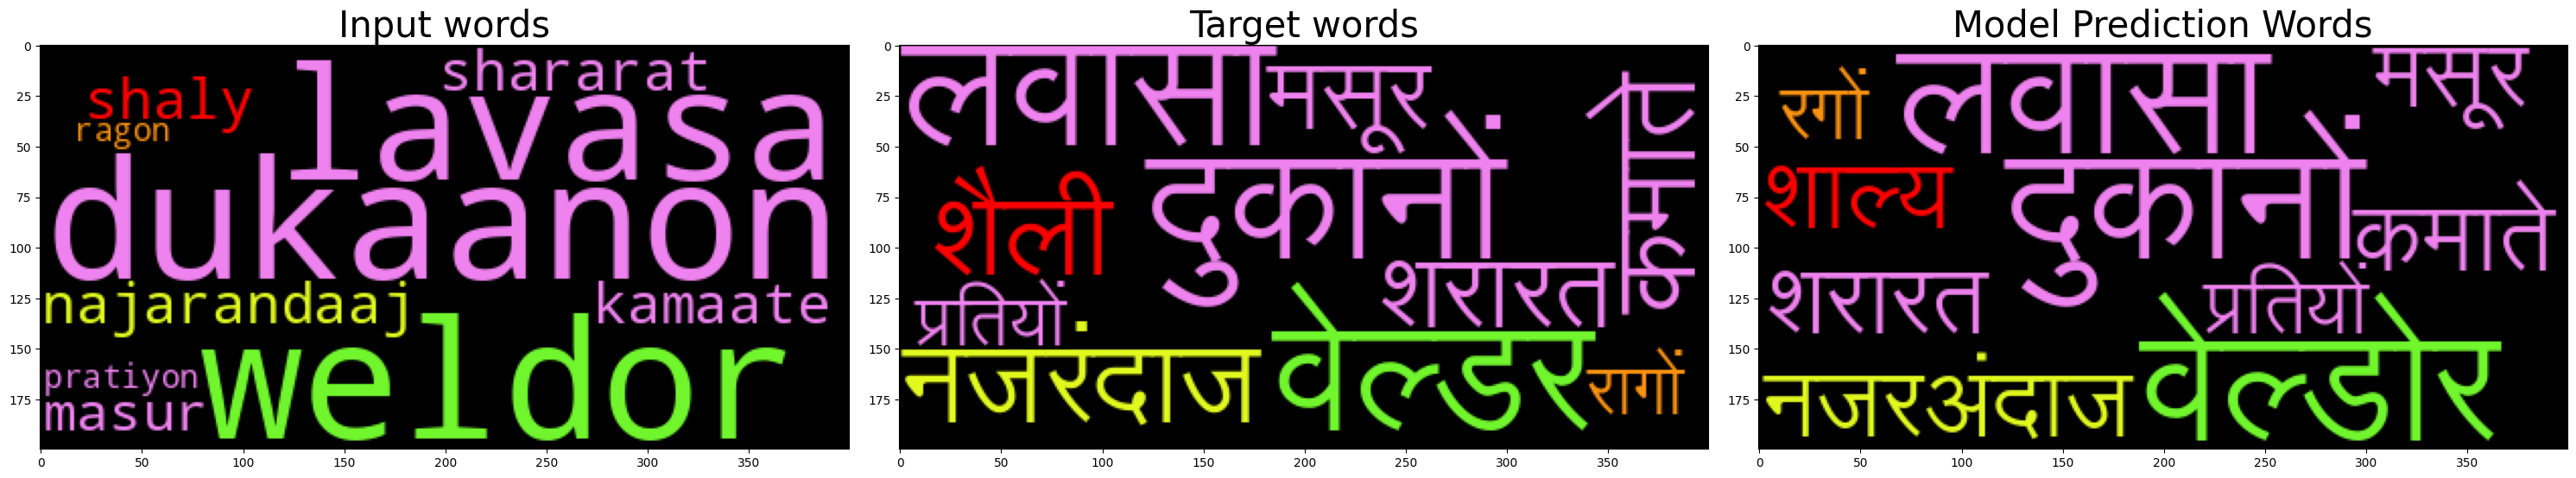

In [19]:
visualize_model_outputs(model, n=10)

In [20]:
def get_test_words(n):
    test_df = pd.read_csv(creating_data("hi")[2])
    test_sample = test_df.sample(n)
    test_sample.reset_index(inplace=True, drop=True)
    test_words = []
    for i in test_sample.index:
        entry = test_sample["अंक\tank\t5"].loc[i]
        parts = entry.split("\t")
        word = parts[1]
        test_words.append(word)
    return test_words

test_words = get_test_words(5)
print(test_words)

['simmy', 'vigyaani', 'shmadan', 'kshitij', 'kpo']


In [21]:
for word in test_words:
    visualise_connectivity(model, word, activation="scaler")

Actual Word: simmy
Transliterated Word: सिम्मी
Visualization for स :


<ipython-input-17-eef4877bf90d>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Visualization for ि :


Visualization for म :


Visualization for ् :


Visualization for म :


Visualization for ी :


Actual Word: vigyaani
Transliterated Word: विग्यानी
Visualization for व :


<ipython-input-17-eef4877bf90d>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Visualization for ि :


Visualization for ग :


Visualization for ् :


Visualization for य :


Visualization for ा :


Visualization for न :


Visualization for ी :


Actual Word: shmadan
Transliterated Word: शमदान
Visualization for श :


<ipython-input-17-eef4877bf90d>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Visualization for म :


Visualization for द :


Visualization for ा :


Visualization for न :


Actual Word: kshitij
Transliterated Word: क्षितिज
Visualization for क :


<ipython-input-17-eef4877bf90d>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Visualization for ् :


Visualization for ष :


Visualization for ि :


Visualization for त :


Visualization for ि :


Visualization for ज :


Actual Word: kpo
Transliterated Word: केपो
Visualization for क :


<ipython-input-17-eef4877bf90d>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = int(value * 19)


Visualization for े :


Visualization for प :


Visualization for ो :


In [22]:
Evaluating_Random_words(model, n=5)

Arbitrarily evaluating the model on 5 words

Input word: kamzor
Actual translation of the word: कमज़ोर
Model translation of the word: कामजोर

Input word: karoor
Actual translation of the word: करूर
Model translation of the word: करूर

Input word: saval
Actual translation of the word: सवाल
Model translation of the word: सावल

Input word: lenset
Actual translation of the word: लैंसेट
Model translation of the word: लेन्सेट

Input word: lakiron
Actual translation of the word: लकीरों
Model translation of the word: लेकिरों



In [23]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: na21b075 (na21b075-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [24]:
def Train_Our_Model(lang, test_beam_search=False):

    config_defaults = {"embeded_dim": 64,
                       "Teacher_forcing_ratio": 1.0,
                       "type_of_Layer": "lstm",
                       "decorder_encoder_layers": 1,
                       "units": 128,
                       "dropout": 0.1,
                       "Attention": False,
                       "Beam_width": 3,
                       "epochs":15
                       }

    wandb.init(config=config_defaults, project="Assignment_3", resume=True)

    ## 1. SELECT lang ##
    TRAIN_TSV, VAL_TSV, TEST_TSV = creating_data(lang)


    ## 2. DATA PREPROCESSING ##
    dataframe = pd.read_csv(TRAIN_TSV, sep="\t", header=None)
    def add_tokens(s, sos="\t", eos="\n"):
        return sos + str(s) + eos
    cols = [0,1]
    for col in cols:
        dataframe[col] = dataframe[col].apply(add_tokens)

    tokenizer = None
    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(dataframe[1].astype(str).tolist())
    lang_tensor = tokenizer.texts_to_sequences(dataframe[1].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')
    input_lang_tensor, input_tokenizer = lang_tensor, tokenizer

    tokenizer = None
    if tokenizer is None:
        tokenizer = Tokenizer(char_level=True)
        tokenizer.fit_on_texts(dataframe[0].astype(str).tolist())
    lang_tensor = tokenizer.texts_to_sequences(dataframe[0].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')

    targ_lang_tensor, targ_tokenizer = lang_tensor, tokenizer
    dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    dataset = dataset.shuffle(len(dataset))

    dataframe = pd.read_csv(VAL_TSV, sep="\t", header=None)
    def add_tokens(s, sos="\t", eos="\n"):
        return sos + str(s) + eos
    cols = [0,1]
    for col in cols:
        dataframe[col] = dataframe[col].apply(add_tokens)
    lang_tensor = tokenizer.texts_to_sequences(dataframe[1].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')
    input_lang_tensor = lang_tensor

    lang_tensor = tokenizer.texts_to_sequences(dataframe[0].astype(str).tolist())
    lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,padding='post')
    targ_lang_tensor = lang_tensor
    val_dataset = tf.data.Dataset.from_tensor_slices((input_lang_tensor, targ_lang_tensor))
    val_dataset = dataset.shuffle(len(val_dataset))

    ## 3. CREATING THE MODEL ##
    model = Seq2SeqModel(embed_dim=wandb.config.embeded_dim,enc_layers=wandb.config.decorder_encoder_layers,dec_layers=wandb.config.decorder_encoder_layers, type_layer=wandb.config.type_of_Layer, units=wandb.config.units,dropout=wandb.config.dropout,loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metric = tf.keras.metrics.SparseCategoricalAccuracy(),attention=wandb.config.Attention)
    ## 4. COMPILING THE MODEL
    model.input_tokenizer = input_tokenizer
    model.targ_tokenizer = targ_tokenizer
    model.create_model()


    ## 5. FITTING AND VALIDATING THE MODEL
    model.fit(dataset, val_dataset, epochs=wandb.config.epochs, use_wandb=True, teacher_forcing_ratio=wandb.config.Teacher_forcing_ratio)

    if test_beam_search:
        ## OPTIONAL :- Evaluate the dataset using beam search and without beam search
        val_dataset, _, _ = preprocess_data(val_dataset, model.input_tokenizer, model.targ_tokenizer)
        subset = val_dataset.take(500)

        # a) Without beam search
        _, test_acc_without = model.evaluate(subset, batch_size=100)
        wandb.log({"Test acc": test_acc_without})

        # b) With beam search
        beam_search = BeamSearch(model=model, k=wandb.config.beam_width)
        beam_search.evaluate(subset, batch_size=100, use_wandb=True)

In [25]:
sweep_config = {
  "name": "Sweep_Assignment3",
  "method": "random",
  "parameters": {
        "decorder_encoder_layers": {
           "values": [1, 2, 3]
        },
        "units": {
            "values": [64, 128, 256]
        },
        "type_of_Layer": {
            "values": ["gru", "rnn","lstm"]
        },
         "embeded_dim": {
            "values": [256,64, 128]
        },
        "dropout": {
            "values": [0.29, 0.37]
        },
        "Beam_width": {
            "values": [3, 7, 5]
        },
        "Teacher_forcing_ratio": {
            "values": [0.9, 0.5,0.2]
        },
        "Attention": {
            "values": [True,False]
        },
        "epochs":{
            "values":[10,20,30]
        }

    }
}

In [26]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_3")

Create sweep with ID: 4tk77i93
Sweep URL: https://wandb.ai/na21b075-indian-institute-of-technology-madras/Assignment_3/sweeps/4tk77i93


In [ ]:
wandb.agent(sweep_id, function=lambda: Train_Our_Model("hi"))

wandb: Agent Starting Run: n7hevdp2 with config:
wandb: 	Attention: False
wandb: 	Beam_width: 3
wandb: 	Teacher_forcing_ratio: 0.2
wandb: 	decorder_encoder_layers: 3
wandb: 	dropout: 0.37
wandb: 	embeded_dim: 128
wandb: 	epochs: 20
wandb: 	type_of_Layer: lstm
wandb: 	units: 256


Epoch 1
Training ...
Validating ...
Train Loss: 1.2154, Accuracy: 64.86% | Val Loss: 1.1383, Accuracy: 68.73%
Epoch 2
Training ...
Validating ...
Train Loss: 1.0163, Accuracy: 70.84% | Val Loss: 1.1111, Accuracy: 69.57%
Epoch 3
Training ...
Validating ...
Train Loss: 0.9043, Accuracy: 73.17% | Val Loss: 1.0553, Accuracy: 72.75%
Epoch 4
Training ...
Validating ...
Train Loss: 0.7867, Accuracy: 76.25% | Val Loss: 0.9430, Accuracy: 75.11%
Epoch 5
Training ...
Validating ...
Train Loss: 0.6885, Accuracy: 78.56% | Val Loss: 0.8441, Accuracy: 76.91%
Epoch 6
Training ...
Validating ...
Train Loss: 0.5823, Accuracy: 81.20% | Val Loss: 0.7638, Accuracy: 79.30%
Epoch 7
Training ...
Validating ...
Train Loss: 0.4876, Accuracy: 84.02% | Val Loss: 0.7127, Accuracy: 81.37%
Epoch 8
Training ...
Validating ...
Train Loss: 0.4184, Accuracy: 86.25% | Val Loss: 0.6387, Accuracy: 83.10%
Epoch 9
Training ...
Validating ...
Train Loss: 0.3699, Accuracy: 87.74% | Val Loss: 0.5920, Accuracy: 84.65%
Epoch 10
T

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train acc,▁▂▃▄▄▅▅▆▆▇▇▇▇▇██████
train loss,█▇▆▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
training time,▁▁▁▁▂▂▂▄▄▄▅▅▅▅▇▇▇███
val acc,▁▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇████
val loss,██▇▆▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
epoch,20
train acc,94.86668
train loss,0.15224
training time,1747757834.49296
val acc,92.9038


wandb: Agent Starting Run: 9nazoacy with config:
wandb: 	Attention: False
wandb: 	Beam_width: 3
wandb: 	Teacher_forcing_ratio: 0.9
wandb: 	decorder_encoder_layers: 2
wandb: 	dropout: 0.37
wandb: 	embeded_dim: 256
wandb: 	epochs: 20
wandb: 	type_of_Layer: rnn
wandb: 	units: 64


Epoch 1
Training ...
Validating ...
Train Loss: 1.0243, Accuracy: 68.53% | Val Loss: 1.4758, Accuracy: 68.58%
Epoch 2
Training ...
Validating ...
Train Loss: 0.7561, Accuracy: 78.37% | Val Loss: 1.5070, Accuracy: 69.07%
Epoch 3
Training ...
Validating ...
Train Loss: 0.6726, Accuracy: 80.45% | Val Loss: 1.5228, Accuracy: 70.20%
Epoch 4
Training ...
Validating ...
Train Loss: 0.6174, Accuracy: 81.70% | Val Loss: 1.4494, Accuracy: 72.11%
Epoch 5
Training ...
Validating ...
Train Loss: 0.5714, Accuracy: 82.80% | Val Loss: 1.5036, Accuracy: 71.88%
Epoch 6
Training ...
Validating ...
Train Loss: 0.5336, Accuracy: 83.63% | Val Loss: 1.3910, Accuracy: 74.69%
Epoch 7
Training ...
Validating ...
Train Loss: 0.5049, Accuracy: 84.51% | Val Loss: 1.3609, Accuracy: 75.05%
Epoch 8
Training ...
Validating ...
Train Loss: 0.4819, Accuracy: 84.98% | Val Loss: 1.3589, Accuracy: 75.43%
Epoch 9
Training ...
Validating ...
Train Loss: 0.4613, Accuracy: 85.69% | Val Loss: 1.3255, Accuracy: 76.03%
Epoch 10
T

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train acc,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
training time,▁▁▁▂▂▂▃▃▅▅▅▆▆▆▇▇▇███
val acc,▁▁▂▃▃▅▅▆▆▆▆▇▇▇▇▇████
val loss,▇██▆▇▄▃▃▂▂▃▂▂▂▂▂▁▁▂▂
epoch,20
train acc,88.72397
train loss,0.35343
training time,1747758762.593
val acc,78.97002


wandb: Agent Starting Run: rvur21hx with config:
wandb: 	Attention: False
wandb: 	Beam_width: 3
wandb: 	Teacher_forcing_ratio: 0.9
wandb: 	decorder_encoder_layers: 2
wandb: 	dropout: 0.29
wandb: 	embeded_dim: 128
wandb: 	epochs: 10
wandb: 	type_of_Layer: lstm
wandb: 	units: 256


Epoch 1
Training ...
Validating ...
Train Loss: 1.0607, Accuracy: 68.36% | Val Loss: 1.5126, Accuracy: 66.79%
Epoch 2
Training ...
Validating ...
Train Loss: 0.8151, Accuracy: 75.23% | Val Loss: 1.5490, Accuracy: 67.53%
Epoch 3
Training ...
Validating ...
Train Loss: 0.6557, Accuracy: 79.08% | Val Loss: 1.4319, Accuracy: 70.98%
Epoch 4
Training ...
Validating ...
Train Loss: 0.5263, Accuracy: 82.79% | Val Loss: 1.2934, Accuracy: 74.16%
Epoch 5
Training ...
Validating ...
Train Loss: 0.4099, Accuracy: 86.22% | Val Loss: 1.1555, Accuracy: 77.66%
Epoch 6
Training ...
Validating ...
Train Loss: 0.3139, Accuracy: 89.42% | Val Loss: 1.0133, Accuracy: 81.24%
Epoch 7
Training ...
Validating ...
Train Loss: 0.2497, Accuracy: 91.59% | Val Loss: 0.9409, Accuracy: 83.98%
Epoch 8
Training ...
Validating ...
Train Loss: 0.2086, Accuracy: 92.99% | Val Loss: 0.8780, Accuracy: 85.13%
Epoch 9
Training ...
Validating ...
Train Loss: 0.1791, Accuracy: 94.04% | Val Loss: 0.8054, Accuracy: 86.88%
Epoch 10
T

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▄▅▆▇▇███
train loss,█▆▅▄▃▂▂▁▁▁
training time,▁▁▁▁▅▅▅▅▅█
val acc,▁▁▂▃▅▆▇▇██
val loss,██▇▆▅▃▃▂▁▁
epoch,10
train acc,94.79666
train loss,0.15795
training time,1747759055.79756
val acc,88.10734


wandb: Agent Starting Run: 1504qmlq with config:
wandb: 	Attention: False
wandb: 	Beam_width: 3
wandb: 	Teacher_forcing_ratio: 0.9
wandb: 	decorder_encoder_layers: 2
wandb: 	dropout: 0.37
wandb: 	embeded_dim: 256
wandb: 	epochs: 10
wandb: 	type_of_Layer: lstm
wandb: 	units: 128


Epoch 1
Training ...
Validating ...
Train Loss: 1.0822, Accuracy: 68.06% | Val Loss: 1.4493, Accuracy: 65.99%
Epoch 2
Training ...
Validating ...
Train Loss: 0.7606, Accuracy: 76.31% | Val Loss: 1.4241, Accuracy: 68.77%
Epoch 3
Training ...
Validating ...
Train Loss: 0.5686, Accuracy: 81.75% | Val Loss: 1.1908, Accuracy: 73.86%
Epoch 4
Training ...
Validating ...
Train Loss: 0.4370, Accuracy: 85.60% | Val Loss: 1.0805, Accuracy: 77.04%
Epoch 5
Training ...
Validating ...
Train Loss: 0.3528, Accuracy: 88.18% | Val Loss: 1.0112, Accuracy: 79.38%
Epoch 6
Training ...
Validating ...
Train Loss: 0.3003, Accuracy: 90.00% | Val Loss: 0.9593, Accuracy: 80.96%
Epoch 7
Training ...
Validating ...
Train Loss: 0.2634, Accuracy: 91.14% | Val Loss: 0.9095, Accuracy: 82.43%
Epoch 8
Training ...
Validating ...
Train Loss: 0.2377, Accuracy: 92.07% | Val Loss: 0.8583, Accuracy: 83.23%
Epoch 9
Training ...
Validating ...
Train Loss: 0.2171, Accuracy: 92.71% | Val Loss: 0.8754, Accuracy: 84.19%
Epoch 10
T

epoch,▁▂▃▃▄▅▆▆▇█
train acc,▁▃▅▆▇▇▇███
train loss,█▅▄▃▂▂▁▁▁▁
training time,▁▁▁▅▅▅▅███
val acc,▁▂▄▅▆▇▇▇██
val loss,██▅▄▃▂▂▁▁▁
epoch,10
train acc,93.32487
train loss,0.20162
training time,1747759349.55752
val acc,84.9097


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c7378mbu with config:
wandb: 	Attention: False
wandb: 	Beam_width: 7
wandb: 	Teacher_forcing_ratio: 0.2
wandb: 	decorder_encoder_layers: 3
wandb: 	dropout: 0.29
wandb: 	embeded_dim: 64
wandb: 	epochs: 10
wandb: 	type_of_Layer: rnn
wandb: 	units: 64


Epoch 1
Training ...
